Machine Learning and Data Analysis

Project - Obstacle avoidance using Machine Learning algorithm in ROS.

Description of the Project:
Developed by Jerin Joy and Koushikmani Maskalmatti Lakshman under the guidance of professor Luca Oneto.
This project demonstrates the implementation of obstacle avoidance in ROS (Robot Operating System) using various machine learning classifiers such as Neural Networks, Random Forest, KNN, and decision tree. The purpose of this project is to create a robot that can navigate autonomously without colliding into any obstacles in its path.



In [100]:
%%capture

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve, validation_curve, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, multilabel_confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.python.keras.metrics import Accuracy, Precision, Recall, AUC, CategoricalAccuracy

In [3]:
# Read Data
columns = []
for i in range(120):
    columns.append(f'x_{i}')

columns = columns + ['v', 'w']

df = pd.read_csv('data.csv')
df.replace([np.inf], 3.5, inplace=True)

df.columns = columns
df.loc[df['v'] == 0.3, "v"] = 1
df.loc[df['v'] == 0.3, "w"] = 0
df.loc[df['w'] == 0.3, "v"] = 0
df.loc[df['w'] == 0.3, "w"] = 1

print("Raw Data")
print(df.head(5))
print(f"Number of Data Entries: {len(df)}")
print(f"Number of v Entries: {len(df[df['v'] == 1])}")
print(f"Number of w Entries: {len(df[df['w'] == 1])}")

Raw Data
        x_0       x_1       x_2       x_3       x_4       x_5       x_6  \
0  1.757790  1.756795  1.747663  1.767158  1.765271  1.779900  1.762095   
1  1.748229  1.764128  1.739702  1.747016  1.753816  1.740524  1.761002   
2  1.715352  1.709566  1.709361  1.717771  1.728112  1.720871  1.724907   
3  1.670870  1.674756  1.662285  1.673070  1.666844  1.656339  1.689519   
4  1.617006  1.601120  1.595978  1.622197  1.605366  1.617249  1.617327   

        x_7       x_8       x_9  ...     x_112     x_113     x_114     x_115  \
0  1.772469  1.754512  1.766275  ...  1.790406  1.763388  1.749376  1.749038   
1  1.769007  1.759623  1.780307  ...  1.745286  1.774112  1.745656  1.754775   
2  1.712213  1.739454  1.727565  ...  1.719604  1.711219  1.714881  1.732098   
3  1.667948  1.683522  1.694583  ...  1.672852  1.687144  1.668343  1.683015   
4  1.624864  1.617897  1.622327  ...  1.615128  1.621961  1.622301  1.580144   

      x_116     x_117     x_118     x_119    v    w  
0  1.

In [4]:
# Split into features and labels
X = df.drop(['v', 'w'], axis=1)
y = df[['v', 'w']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


print("Prepared Data")
print("y_train Dataframe\n")
print(y_train.head(5))

print("X_train Dataframe\n")
print(X_train.head(5))


Prepared Data
y_train Dataframe

         v    w
43863  0.0  1.0
67351  0.0  1.0
55481  1.0  0.0
10724  0.0  1.0
57773  1.0  0.0
X_train Dataframe

            x_0       x_1       x_2       x_3       x_4       x_5       x_6  \
43863  2.441709  2.483620  2.541319  2.588968  2.638444  2.678917  2.739196   
67351  1.774071  2.015963  2.386438  2.916492  3.418988  3.408353  3.426925   
55481  0.425189  0.415537  0.424897  0.406838  0.397739  0.410233  0.378173   
10724  3.500000  3.500000  3.500000  2.539820  2.521772  2.551445  3.500000   
57773  3.306483  3.205808  3.119955  3.023582  2.953182  1.261921  1.209744   

            x_7       x_8       x_9  ...     x_110     x_111     x_112  \
43863  2.807427  2.856613  2.929956  ...  2.140733  2.176810  2.217819   
67351  3.399066  3.416911  3.429713  ...  0.805999  0.863443  0.941659   
55481  0.380399  0.380356  0.391224  ...  0.488518  0.476274  0.461388   
10724  3.500000  3.500000  3.500000  ...  3.280444  3.298074  1.332962   
57773  

In [36]:
# Decision Tree Classifier
dt_model = DecisionTreeClassifier()

# Random Forest Classifier
rf_model = RandomForestClassifier()

# K-Nearest Neighbors Classifier
knn_model = KNeighborsClassifier()

# Tensorflow Neural Network Classifier
nn_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

nn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']);

In [76]:
# Define a function to evaluate a model using cross-validation and k-fold
def evaluate_model(model, X_train, y_train):
    # Define number of folds
    k = 5
    
    # Create a KFold object
    kf = KFold(n_splits=k)
    
    # Initialize lists to store scores for each fold
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    roc_auc_scores = []
    f1_scores = []
    cm_list = []
    
    # Loop over each fold
    for train_index, test_index in kf.split(X_train):
        # Split data into train and test sets for this fold
        X_train_fold = X_train.iloc[train_index]
        y_train_fold = y_train.iloc[train_index]
        X_test_fold = X_train.iloc[test_index]
        y_test_fold = y_train.iloc[test_index]
        
        # Convert data into tensors if model is TensorFlow Keras model
        if isinstance(model, tf.keras.models.Sequential):
            X_train_fold = tf.convert_to_tensor(X_train_fold)
            y_train_fold = tf.convert_to_tensor(y_train_fold)
            X_test_fold = tf.convert_to_tensor(X_test_fold)
            y_test_fold = tf.convert_to_tensor(y_test_fold)
        
        # Fit model on train set
        model.fit(X_train_fold,y_train_fold)
        
        # Predict on test set
        y_pred_fold = model.predict(X_test_fold)
        
        # Compute scores for this fold if model is TensorFlow Keras model
        if isinstance(model, tf.keras.models.Sequential):
            nn_accuracy = tf.keras.metrics.CategoricalAccuracy()(y_test_fold, y_pred_fold)
            nn_precision = tf.keras.metrics.Precision()(y_test_fold, y_pred_fold)
            nn_recall = tf.keras.metrics.Recall()(y_test_fold, y_pred_fold)
            nn_roc = tf.keras.metrics.AUC()(y_test_fold, y_pred_fold)
            nn_f1 = 2 * ((nn_precision * nn_recall) / (nn_precision + nn_recall + 1e-10))
            accuracy_scores.append(nn_accuracy)
            precision_scores.append(nn_precision)
            recall_scores.append(nn_recall)
            roc_auc_scores.append(nn_roc)
            f1_scores.append(nn_f1)
            
            # Compute confusion matrix for this fold if model is TensorFlow Keras model  
            y_pred_classes = tf.argmax(y_pred_fold, axis=1)
            y_test_classes = tf.argmax(y_test_fold, axis=1)
            cm = tf.math.confusion_matrix(y_test_classes, y_pred_classes)  
            cm_list.append(cm)  
            continue
            
        # Compute scores for this fold
        accuracy_scores.append(accuracy_score(y_test_fold,y_pred_fold))
        precision_scores.append(precision_score(y_test_fold,y_pred_fold, average = 'micro'))
        recall_scores.append(recall_score(y_test_fold,y_pred_fold, average = 'micro'))
        roc_auc_scores.append(roc_auc_score(y_test_fold,y_pred_fold, average = 'micro'))
        f1_scores.append(f1_score(y_test_fold,y_pred_fold, average = 'micro'))
        
        # Compute confusion matrix for this fold   
        cm = multilabel_confusion_matrix(y_test_fold,y_pred_fold)   
        cm_list.append(cm) 
    
    # Return the mean scores across all folds
    return np.mean(accuracy_scores), np.mean(precision_scores), np.mean(recall_scores), np.mean(roc_auc_scores), np.mean(f1_scores), cm_list

In [77]:
nn_accuracy, nn_precision, nn_recall, nn_roc_auc, nn_f1, nn_cm = evaluate_model(nn_model,X,y)

475/475 [==============================] - 1s 1ms/step


In [73]:
# Evaluate each model using cross-validation and k-fold
dt_accuracy, dt_precision, dt_recall, dt_roc_auc, dt_f1, dt_cm = evaluate_model(dt_model,X,y)
rf_accuracy, rf_precision, rf_recall, rf_roc_auc, rf_f1, rf_cm = evaluate_model(rf_model,X,y)
knn_accuracy, knn_precision, knn_recall, knn_roc_auc, knn_f1, knn_cm = evaluate_model(knn_model,X,y)
nn_accuracy, nn_precision, nn_recall, nn_roc_auc, nn_f1, nn_cm = evaluate_model(nn_model,X,y)

475/475 [==============================] - 1s 1ms/step


TypeError: multilabel_confusion_matrix() missing 1 required positional argument: 'y_pred'

In [45]:
# Open a file in write mode
f = open('results.txt', 'w')

# Print the results to the file
print("Decision Tree: Accuracy: {}, Precision: {}, Recall: {}, ROC AUC: {}, F1: {}".format(dt_accuracy,
                                                                                           dt_precision,
                                                                                           dt_recall,
                                                                                           dt_roc_auc,
                                                                                           dt_f1), file=f)

print("Random Forest: Accuracy: {}, Precision: {}, Recall: {}, ROC AUC: {}, F1: {}".format(rf_accuracy,
                                                                                           rf_precision,
                                                                                           rf_recall,
                                                                                           rf_roc_auc,
                                                                                           rf_f1), file=f)

print("KNN: Accuracy: {}, Precision: {}, Recall: {}, ROC AUC: {}, F1: {}".format(knn_accuracy,
                                                                                 knn_precision,
                                                                                 knn_recall,
                                                                                 knn_roc_auc,
                                                                                 knn_f1), file=f)

print("Neural Network: Accuracy: {}, Precision: {}, Recall: {}, ROC AUC: {}, F1: {}".format(nn_accuracy,
                                                                                            nn_precision,
                                                                                            nn_recall,
                                                                                            nn_roc_auc,
                                                                                            nn_f1), file=f)
# Close the file

f.close()

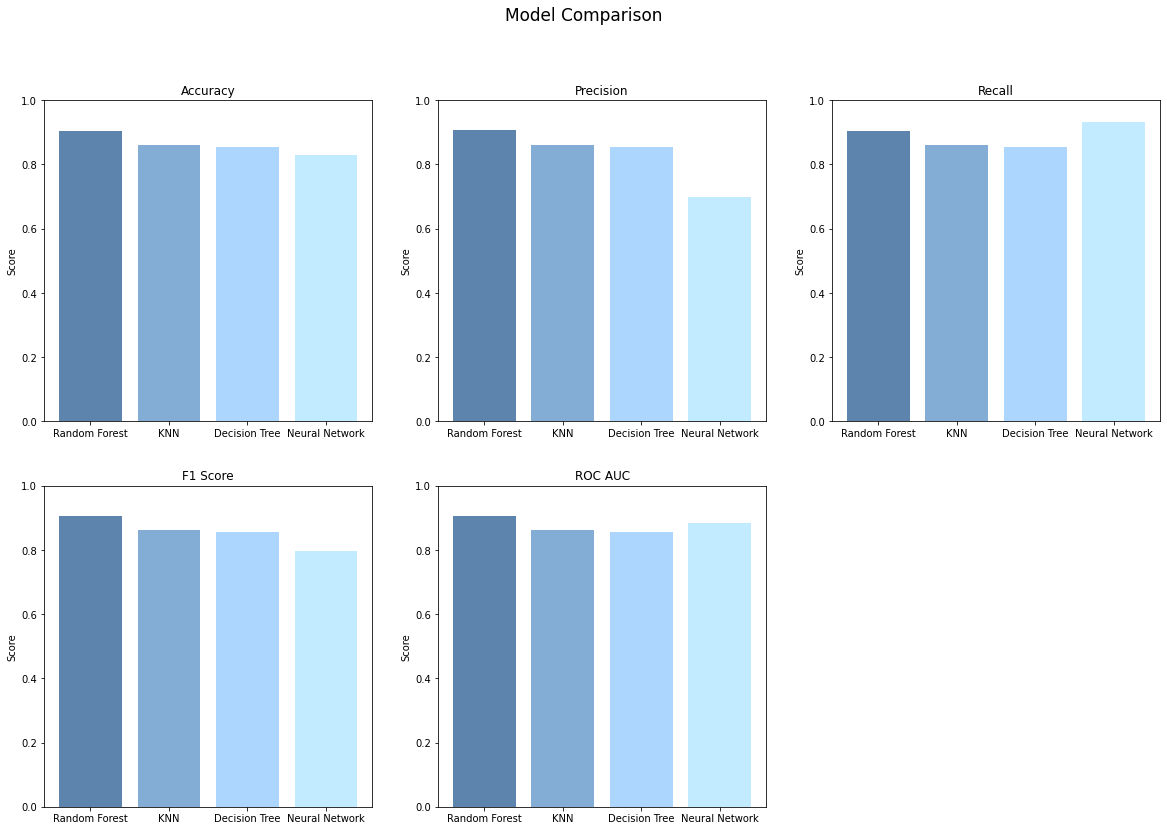

In [70]:
# Define model names and corresponding metrics
model_names = ['Random Forest', 'KNN', 'Decision Tree', 'Neural Network']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']

# Define scores for each model and metric
accuracy_scores = [rf_accuracy, knn_accuracy, dt_accuracy, nn_accuracy]
precision_scores = [rf_precision, knn_precision, dt_precision, nn_precision]
recall_scores = [rf_recall, knn_recall, dt_recall, nn_recall]
f1_scores = [rf_f1, knn_f1, dt_f1, nn_f1]
roc_auc_scores = [rf_roc_auc, knn_roc_auc, dt_roc_auc, nn_roc_auc]

# Define colors for each metric
colors = [(0.2, 0.4, 0.6, 0.8), (0.4, 0.6, 0.8, 0.8), (0.6, 0.8, 1.0, 0.8), (0.7, 0.9, 1.0, 0.8)]

# Define a list of lists for the scores
scores = [accuracy_scores, precision_scores, recall_scores, f1_scores, roc_auc_scores]

# Create a figure with 5 subplots arranged in 2 rows and 3 columns
fig = plt.figure(figsize=(20 ,13))
fig.suptitle('Model Comparison', size = '17')

# Generate plots for each metric
for i ,metric in enumerate(metrics):
    # Get the scores for the current metric
    metric_scores = scores[i]

    # Calculate the average score for each model
    model_scores = [np.mean(metric_scores[j::len(model_names)]) for j in range(len(model_names))]

    # Create a subplot for each metric
    ax = fig.add_subplot(2 ,3 ,i + 1)
    ax.bar(model_names ,model_scores ,color=colors)
    ax.set_ylim(0 ,1)
    ax.set_title(metric)
    ax.set_ylabel('Score')

In [97]:
def plot_confusion_matrix(conf_matrix, model_name):
    n_classes = 1
    fig, axes = plt.subplots(nrows=1, ncols=2 if n_classes > 1 else 1, figsize=(10, 5))
    for i in range(n_classes):
        ax = axes[i] if n_classes > 1 else axes
        sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False, ax=ax)
        ax.set_xlabel('Predicted label')
        ax.set_ylabel('True label')
        ax.set_title(f'Confusion matrix for class {i+1} - {model_name}')
    fig.suptitle(f'{model_name} Confusion Matrix', fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.savefig('confusion_matrix_' + model_name.lower().replace(' ', '_') + '.png')
    plt.show()
    # plt.clf()
    # plt.close()

ValueError: Must pass 2-d input. shape=(5, 2, 2, 2)

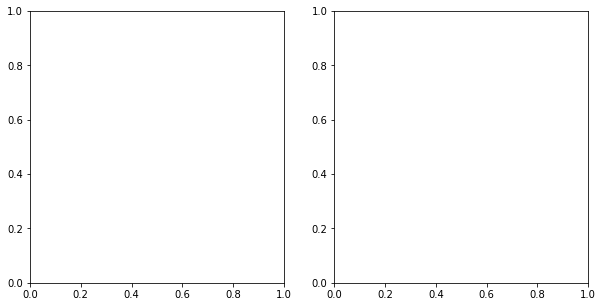

In [88]:
# Plot the confusion matrix for each model
plot_confusion_matrix(rf_cm, "Random Forest")
plot_confusion_matrix(knn_cm[1], "KNN")
plot_confusion_matrix(dt_cm[1], "Decision Tree")
plot_confusion_matrix_tf(nn_cm[1], "Neural Network")

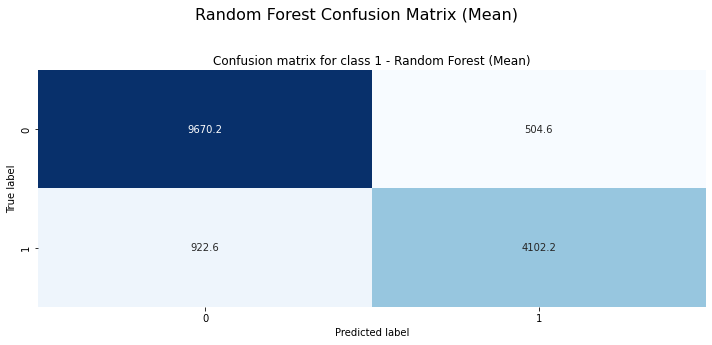

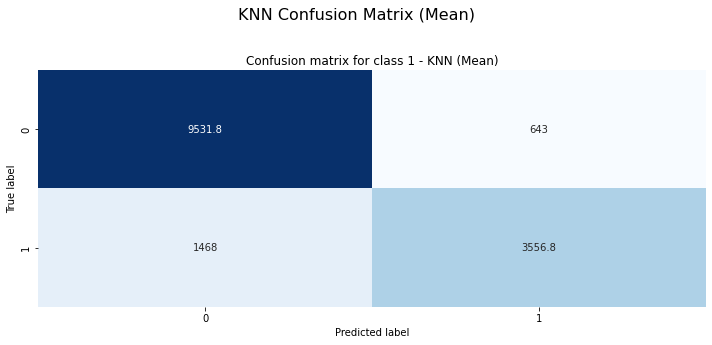

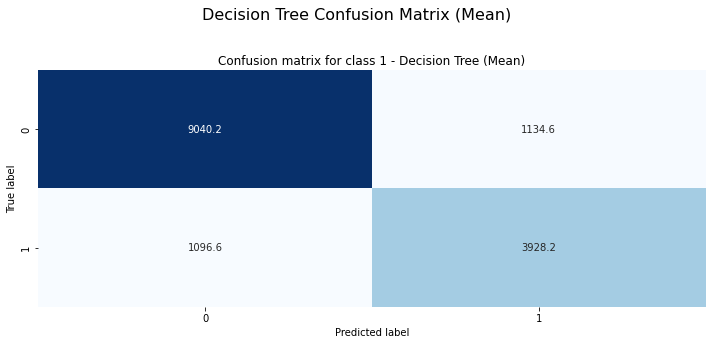

IndexError: Inconsistent shape between the condition and the input (got (2, 1) and (2,))

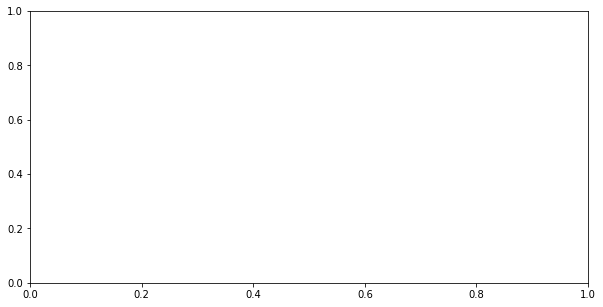

In [117]:
def plot_confusion_matrix(conf_matrices, model_name):
    n_classes = 1
    if isinstance(conf_matrices, list) and all(isinstance(cm, tf.Tensor) and cm.shape == (2, 2) for cm in conf_matrices):
        conf_matrices = np.array([cm.numpy() for cm in conf_matrices])
#     elif not isinstance(conf_matrices, np.ndarray) or conf_matrices.shape[-2:] != (2, 2):
#         raise ValueError('Invalid input: conf_matrices must be a list of tf.Tensor objects with shape (2, 2) or a numpy array with shape (n, 2, 2)')
    mean_conf_matrix = np.mean(conf_matrices, axis=0)
    fig, axes = plt.subplots(nrows=1, ncols=2 if n_classes > 1 else 1, figsize=(10, 5))
    for i in range(1):
        ax = axes[i] if n_classes > 1 else axes
        sns.heatmap(mean_conf_matrix[i], annot=True, cmap='Blues', fmt='g', cbar=False, ax=ax)
        ax.set_xlabel('Predicted label')
        ax.set_ylabel('True label')
        ax.set_title(f'Confusion matrix for class {i+1} - {model_name} (Mean)')
    fig.suptitle(f'{model_name} Confusion Matrix (Mean)', fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.savefig(f'confusion_matrix_{model_name.lower().replace(" ", "_")}_mean.png')
    plt.show()

# Plot the mean confusion matrix for the models.
plot_confusion_matrix(rf_cm, "Random Forest")
plot_confusion_matrix(knn_cm, "KNN")
plot_confusion_matrix(dt_cm, "Decision Tree")
plot_confusion_matrix(nn_cm, "Neural Network")


[<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[3938, 1092],
       [1581, 8589]], dtype=int32)>, <tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[3786, 1031],
       [1254, 9129]], dtype=int32)>, <tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[4079, 1017],
       [1575, 8529]], dtype=int32)>, <tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[3437, 1355],
       [1075, 9332]], dtype=int32)>, <tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[4638,  751],
       [1841, 7969]], dtype=int32)>]


IndexError: Inconsistent shape between the condition and the input (got (2, 1) and (2,))

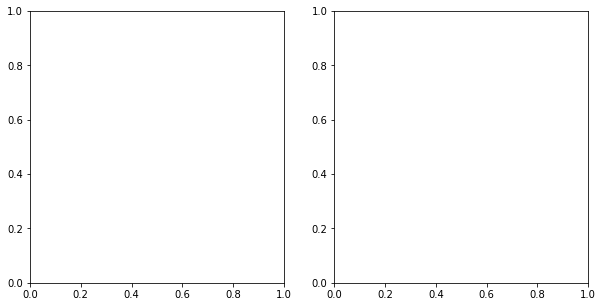

In [112]:
print(nn_cm)

numpy_arrays = [tensor.numpy() for tensor in nn_cm]
list_of_arrays = np.array(numpy_arrays)

plot_confusion_matrix(list_of_arrays, "nn")

print(list_of_arrays)
